# ***Part1***

In [ ]:
# installing extra packages
!pip install distance
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
import os
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

# Commented out IPython magic to ensure Python compatibility.
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

Mounted at /content/gdrive
We're running Colab
Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/MyDrive/W2VEC_PullRequest_VF"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
#   %cd $drive_root

os.chdir(mount +'/MyDrive/RBC_V4')


Colab: making sure  /content/gdrive/MyDrive/W2VEC_PullRequest_VF  exists.

Colab: Changing directory to  /content/gdrive/MyDrive/W2VEC_PullRequest_VF


# ***Exploratory Data Analysis***

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/RBC_V4/W2V_VR4.csv', delimiter=';', encoding='cp437')
print(f'The number of datapoints is {data.shape}')
data.head(5)

The number of datapoints is (3328, 6)


,id,qid1,question1,qid2,question2,is_duplicate
0,0,14082,providerfastly Make requestcondition optional ...,14103,providerfastly Changes setting conditionals to...,1
1,1,6533,add `validatecredentials` option to provideraw...,7874,Skip IAMSTS validation and metadata check Skip...,1
2,2,12737,"Update environments.html.md kind of confusing,...",12781,Documentation Update Fix a code sample that us...,1
3,3,7557,Remove redundant const from command package Re...,7666,command Remove second DefaultDataDirectory con...,1
4,4,6956,provideraws Fixing IAM data source policy gene...,7785,provideraws Normalize IAM policy documents Fix...,1


We have the following columns

**id:** A unique id for the question pair

**qid1:** id of the first question.

**qid2:** id of the second question

**question1:** the first question

**question2:** second question

**is_duplicate:** Whether both are duplicate or not.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3328 non-null   int64 
 1   qid1          3328 non-null   int64 
 2   question1     3328 non-null   object
 3   qid2          3328 non-null   int64 
 4   question2     3328 non-null   object
 5   is_duplicate  3328 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 156.1+ KB


# ***Checking for null values***

In [ ]:
data[data.isnull().any(axis=1)]

,id,qid1,question1,qid2,question2,is_duplicate


In [ ]:
data = data.dropna()
data.shape

(3328, 6)

# ***Check for duplicate entries***

In [ ]:
data[data.drop(columns=['id']).duplicated()]

,id,qid1,question1,qid2,question2,is_duplicate


We don't have any duplicate rows present

# ***Analyzing distribution of target variable***

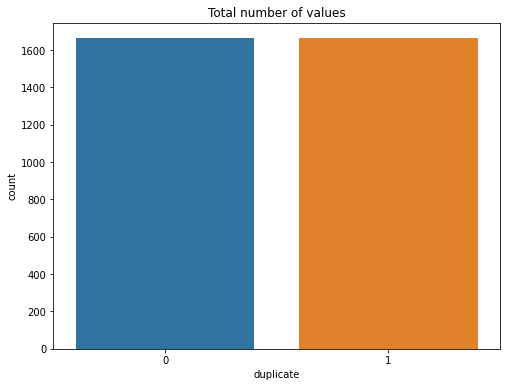

Total number of question pairs is 3328
Question pairs that are similar is 1664 which is 50 % of total
Question pairs that are not similar is 1664 which is 50 % of total


In [ ]:
plt.figure(figsize=(8,6))
ct = data['is_duplicate'].value_counts()
sns.barplot(x=ct.index,y=ct.values)
plt.title('Total number of values')
plt.xlabel('duplicate')
plt.ylabel('count')
plt.show()

print('Total number of question pairs is {}'.format(len(data.id.values)))
print('Question pairs that are similar is {} which is {} % of total'.format(ct[1],round((ct[1]/(ct[1]+ct[0])*100)),2))
print('Question pairs that are not similar is {} which is {} % of total'.format(ct[0],round((ct[0]/(ct[1]+ct[0])*100)),2))

# ***Number of uniques questions and repeated questions***

In [ ]:
qids = pd.Series(data.qid2.tolist() + data.qid1.tolist())
uniq = len(np.unique(qids))
print('Total number of unique questions is {}'.format(uniq))
#Number of questions that repeated than 1 time
cnt = qids.value_counts()
more1 = len(cnt[cnt.values > 1])
print('Number of questions that repeated more than 1 time is {} which is {}%'.format(more1,(more1/(len(cnt))*100)))
print('The maximum number of times a question occured is {}'.format(max(cnt)))

Total number of unique questions is 6132
Number of questions that repeated more than 1 time is 492 which is 8.023483365949119%
The maximum number of times a question occured is 4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


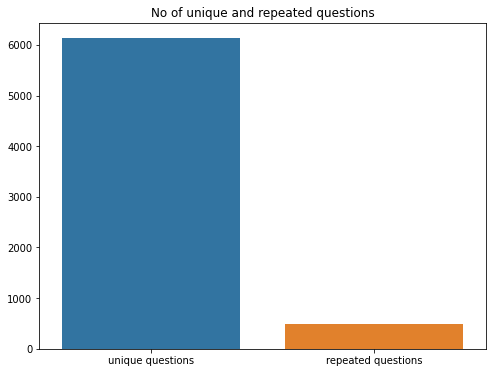

In [ ]:
plt.figure(figsize=(8,6))
x = ['unique questions','repeated questions']
y = [uniq,more1]
sns.barplot(x,y)
plt.title('No of unique and repeated questions')
plt.show()

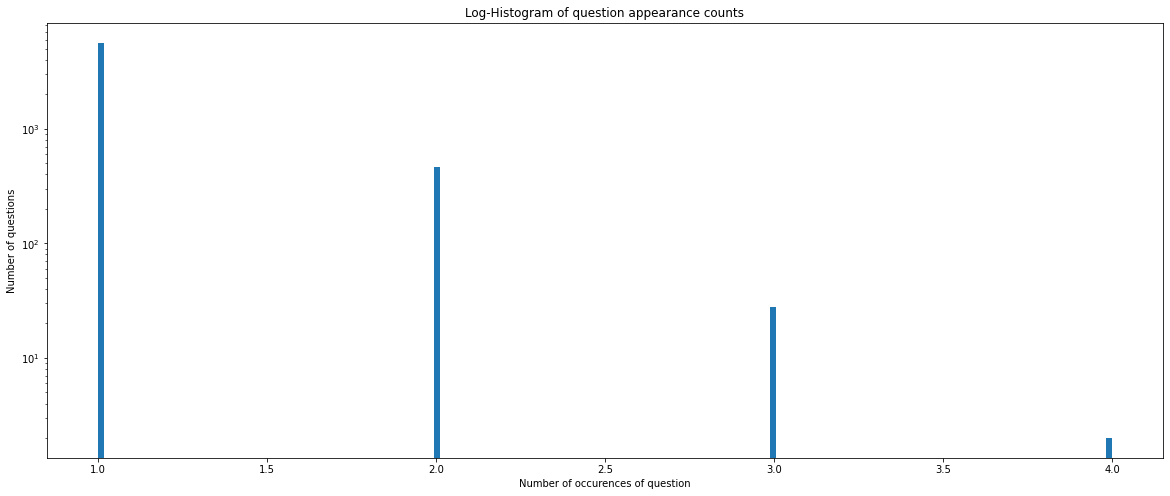

In [ ]:
plt.figure(figsize=(20, 8))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

# ***Basic Feature Engineering(Before cleaning the data)***

Let us now construct a few features like:

**freq_qid1 =** Frequency of qid1's #ie, number of times question1 occur

**freq_qid2 =** Frequency of qid2's

**q1len =** Length of q1

**q2len =** Length of q2

**q1_n_words =** Number of words in Question 1

**q2_n_words =** Number of words in Question 2

**word_Common =** (Number of common unique words in Question 1 and Question 2)

**word_Total =**(Total num of words in Question 1 + Total num of words in Question 2)

**word_share =** (word_common)/(word_Total)

**freq_q1+freq_q2 =** sum total of frequency of qid1 and qid2

**freq_q1-freq_q2 =** absolute difference of frequency of qid1 and qid2

In [ ]:
if os.path.isfile('data_with_out_preprocess.csv'):
    data = pd.read_csv("data_with_out_preprocess.csv",encoding='latin-1')
else:
    def common_wrd(row):
        x = set(row['question1'].lower().strip().split(" ")) 
        y = set(row['question2'].lower().strip().split(" "))
        return 1.0 * len(x & y)


    def total(row):
        set1 = set(row['question1'].lower().strip().split(" "))
        set2 = set(row['question2'].lower().strip().split(" "))
        return 1.0 * (len(set1) + len(set2))

    def word_share(row):
        x = row['word_common']/row['word_total']
        return  x

############################################
    
    data['freq_qid1'] = data['qid1'].apply(lambda x: cnt[x])
    data['freq_qid2'] = data['qid2'].apply(lambda x: cnt[x])
    data['q1len'] = data['question1'].apply(lambda x: len(x))
    data['q2len'] = data['question2'].apply(lambda x: len(x))
    data['q1_n_words'] = data['question1'].apply(lambda x: len(x.split(" ")))
    data['q2_n_words'] = data['question2'].apply(lambda x: len(x.split(" ")))
    data['word_common'] = data.apply(common_wrd,axis=1)
    data['word_total'] = data.apply(total,axis=1)
    data['word_share'] = data.apply(word_share,axis=1)
    data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
    data['freq_q1-q2'] = abs(data['freq_qid1']-data['freq_qid2'])
    data.to_csv("data_with_out_preprocess.csv", index=False)

In [ ]:

data = pd.read_csv(mount +'/MyDrive/RBC_V4/data_with_out_preprocess.csv')
data.head(3)

,id,qid1,question1,qid2,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,14082,providerfastly Make requestcondition optional ...,14103,providerfastly Changes setting conditionals to...,1,2,2,320,283,97,37,9.0,62.0,0.145161,4,0
1,1,6533,add `validatecredentials` option to provideraw...,7874,Skip IAMSTS validation and metadata check Skip...,1,1,2,797,600,187,90,13.0,143.0,0.090909,3,1
2,2,12737,"Update environments.html.md kind of confusing,...",12781,Documentation Update Fix a code sample that us...,1,2,1,244,284,90,44,3.0,66.0,0.045455,3,1


# ***Analysis on extracted features***

In [ ]:
print ("Minimum length of the questions in question1 : " , min(data['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(data['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", data[data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", data[data['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  3
Minimum length of the questions in question2 :  2
Number of Questions with minimum length [question1] : 0
Number of Questions with minimum length [question2] : 0


In [ ]:
data[data['q1_n_words']== 1].head(3)

,id,qid1,question1,qid2,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2


We can see certain questions with single word.Anyway we will keep it and proceed

# ***Analysing word share***

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


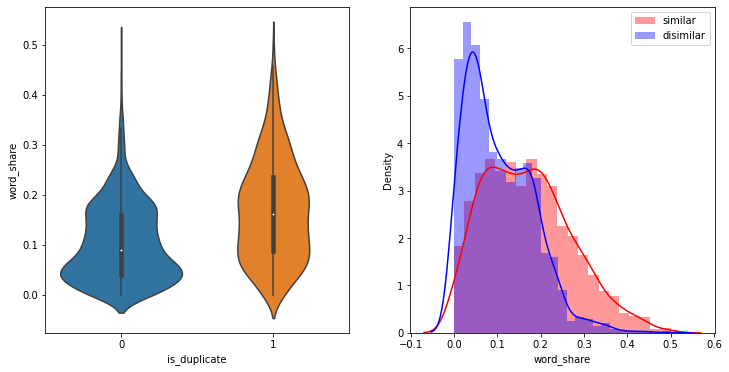

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1]['word_share'],color='red',label='similar')
sns.distplot(data[data['is_duplicate'] == 0]['word_share'],color='blue',label='disimilar')
plt.legend()
plt.show()

We can see that as the word share increases there is a higher chance the questions are similar. From the histogram we can see that word share has some information differentiating similar and dissimilar classes.

# ***Analyzing word_common***

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


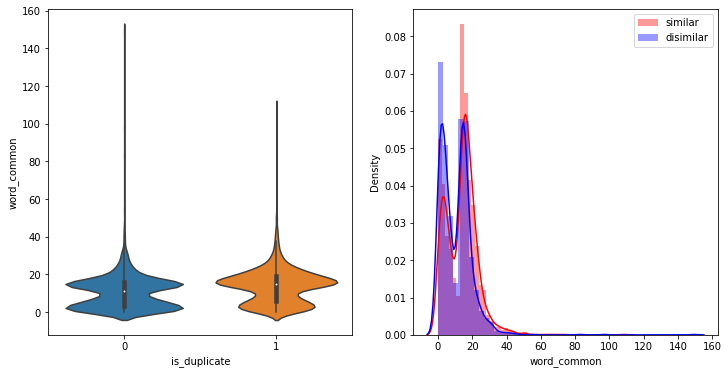

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_common',data=data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1]['word_common'],color='red',label='similar')
sns.distplot(data[data['is_duplicate'] == 0]['word_common'],color='blue',label='disimilar')
plt.legend()
plt.show()

We can see that common_words doesnot have enough information seperating classes.The hist plots of word_common of duplicate and non-duplicate questions are overlapping. Not much information can be retrived as most of pdf's is overlapping.

# ***Analysis on frequency of questions***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


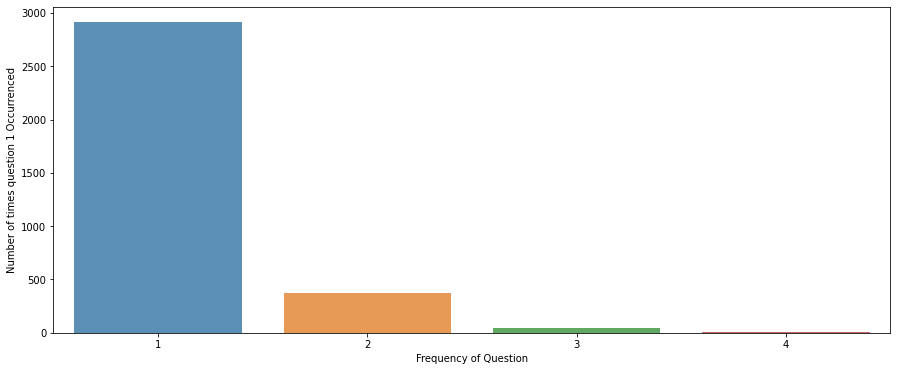

In [ ]:
# Frequency of Question 1
plt.figure(figsize=(15,6))
my_count = data['freq_qid1'].value_counts()
sns.barplot(my_count.index, my_count.values, alpha=0.8)
plt.ylabel('Number of times question 1 Occurrenced', fontsize=10)
plt.xlabel('Frequency of Question', fontsize=10)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


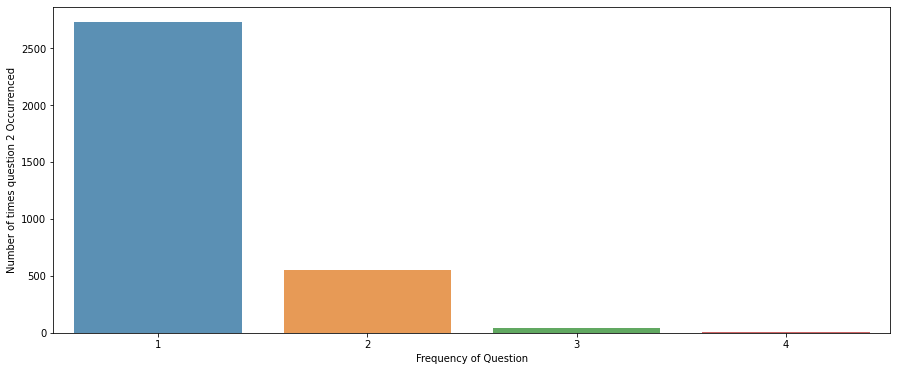

In [ ]:
# Frequency of Question 2
plt.figure(figsize=(15,6))
my_count = data['freq_qid2'].value_counts()
sns.barplot(my_count.index, my_count.values, alpha=0.8)
plt.ylabel('Number of times question 2 Occurrenced', fontsize=10)
plt.xlabel('Frequency of Question', fontsize=10)
plt.show()

# ***Adavanced Feature Engineering***

# Text Preprocessing(Cleaning)

**As a part of text preprocessing, I have done**

Removing html tags

Removing Punctuations

Performing stemming

Removing Stopwords

Expanding contractions etc.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    #replacing multiple digits representation to  miilion,thoudsands etc.. eg:1000 -> 1k
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)  
    
    
    porter = PorterStemmer()    #apply stemming  eg: growing,growth --> grow
    pattern = re.compile('\W')  #matching word charecter
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

More feature engineering:

cwc_min : Ratio of common_word_count to min length of word count of Q1 and Q2
  
cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

cwc_max : Ratio of common_word_count to max length of word count of Q1 and Q2  

cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

csc_min : Ratio of common_stop_count to min length of stop count of Q1 and Q2   

csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

csc_max : Ratio of common_stop_count to max length of stop count of Q1 and Q2 

csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and 

Q2 ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and 

Q2 ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))

last_word_eq : Check if last word of both questions is equal or not 

last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])

first_word_eq : Check if First word of both questions is equal or not 

first_word_eq = int(q1_tokens[0] == q2_tokens[0])
abs_len_diff : Abs. length difference abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

mean_len : Average Token Length of both Questions mean_len = (len(q1_tokens) + len(q2_tokens))/2

fuzz_ratio : Here comes the interesting part. Fuzz ratio depends upon the Levenshtein distance. Intutively saying if the corresponding edits required from one sentance to become other is large, fuzz ratio will be small. ie, fuzz ratio will be similar for most similar words.

eg: s1 = "mumbai is a great place" s2 = "mumbai is a nice place". fuzz ratio = 91

fuzz_partial_ratio : In certain cases fuzz ratio cannot solve the issue.
fuzz.ratio("YANKEES", "NEW YORK YANKEES") ⇒ 60
fuzz.ratio("NEW YORK METS", "NEW YORK YANKEES") ⇒ 75
Both s1 and s2 mean the same. But their fuzz ratio can be smaller. So we will find the ratio for partial sentences and it will be high. In such case, it is known as a fuzz partial ratio.
fuzz.partial_ratio("YANKEES", "NEW YORK YANKEES") ⇒ 60

token_sort_ratio: In some other cases even fuzz partial ratio will fail.

For example:

fuzz.partial_ratio("MI vs RCB","RCB vs MI") ⇒ 72 Actually both the sentence have the same meaning. But the fuzz ratio gives a low result. So a better approach is to sort the tokens and then apply fuzz ratio. fuzz.token_sort_ratio("MI vs RCB","RCB vs MI") ⇒ 100

token_set_ratio: There is another type of fuzz ratio which helps even I cases where all above fails. It is the token set ratio. For that we have to first 

find the following:

t0 -> find the intersection words of sentance1 and sentance2 and sort them.

t1-> t0 + rest of tokens in sentance1.

t2-> t0 + rest of tokens in sentance2.
tocken_set_ratio = max(fuzz_ratio(to,t1),fuzz_ratio(t1,t2),fuzz_ratio(t0,t2))

longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2. 

s1-> hai, today is a good day

s2-> No, today is a bad day

Here longest common substring is "today is a". So we have longest_substring_ratio = 3 / min(6,6) = 0.5 longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    SAFE_DIV = 0.0001 
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))      # will return longest common substring 
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # To get the results in 4 decemal points
    
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
df = extract_features(data)
df.to_csv(mount +"/MyDrive/RBC_V4/data_with_preprocess_2.csv", index=False)

token features...
fuzzy features..


In [ ]:
df = pd.read_csv(mount +"/MyDrive/RBC_V4/data_with_preprocess_2.csv")
print(df.shape)
df.head(2)

(3328, 32)


,id,qid1,question1,qid2,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,14082,providerfastly make requestcondition optional ...,14103,providerfastly changes setting conditionals to...,1,2,2,320,283,...,0.351350,0,1,6,34.0,67,19,6,16,0.063380
1,1,6533,add validatecredentials option to provideraw...,7874,skip iamsts validation and metadata check skip...,1,1,2,797,600,...,0.122951,0,0,34,105.0,31,2,2,3,0.024917


# ***Plotting Word Clouds***

Plotting Word Clouds help us to undertand important words/features.

In [ ]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

In [ ]:
sent_dup =np.dstack([df_duplicate['question1'].values,df_duplicate['question2'].values])
#words_dup = [word for sublist in sent_dup for word in sublist]
words_dup = sent_dup.flatten()
######
sent_ndup =np.dstack((df_nonduplicate['question1'].values,df_nonduplicate['question2'].values))
#words_ndup = [word for sublist in sent_ndup for word in sublist]
words_ndup = sent_ndup.flatten()

In [ ]:
textp_w = words_dup
#open(path.join(d, 'train_p.txt')).read()
textn_w = words_ndup
#open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))


textn_w = [str(i) for i in textn_w]
textp_w = [str(i) for i in textp_w]
textp_w = ''.join(textp_w)
textn_w = ''.join(textn_w)

Total number of words in duplicate pair questions : 3328
Total number of words in non duplicate pair questions : 3328


# ***Word cloud for duplicate pair of questions***

Word Cloud for Duplicate Question pairs


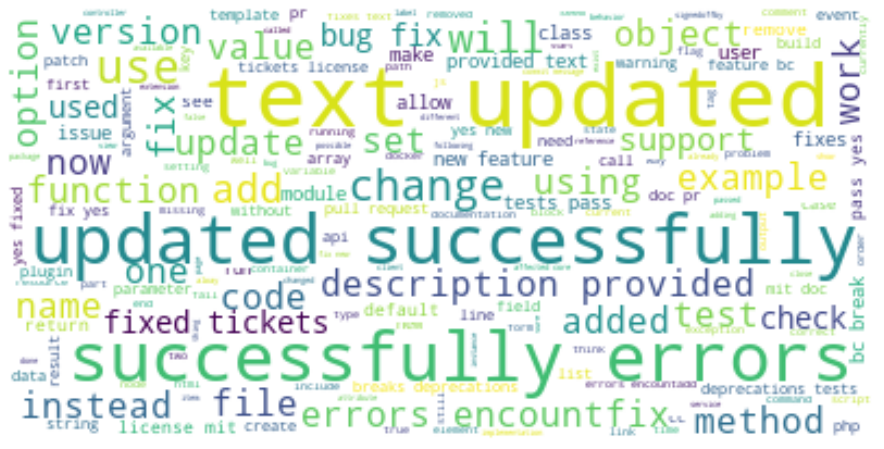

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# ***Word cloud for non duplicate pair of questions***

Word Cloud for Non Duplicate Question pairs


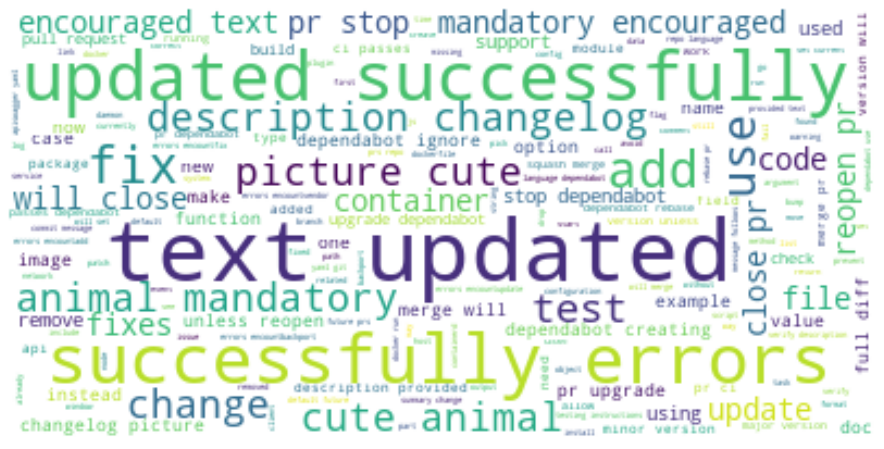

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# ***Pair plot of features ['ctc_min', 'cwc_min', 'csc_min' 'token_sort_ratio']***

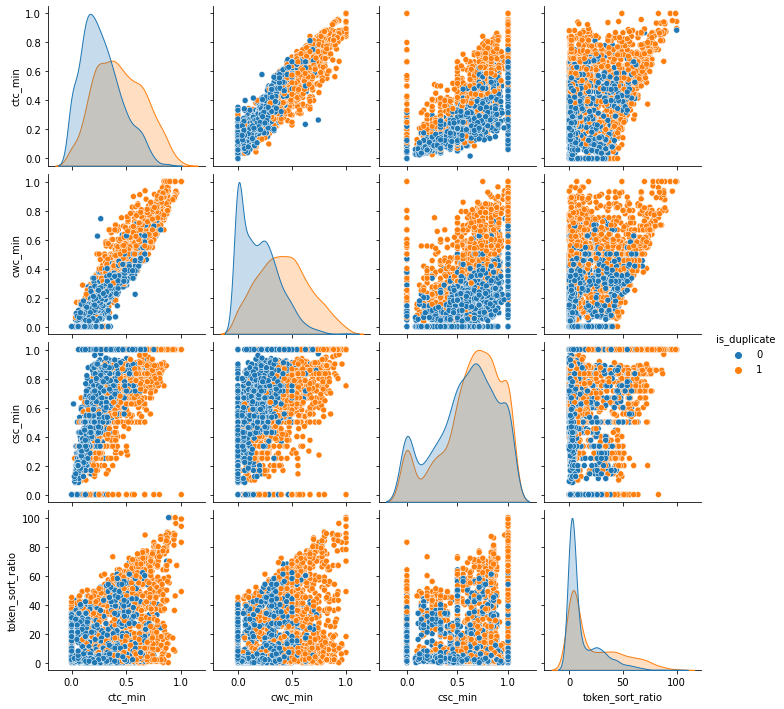

<Figure size 1152x576 with 0 Axes>

In [ ]:
sns.pairplot(df, hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.figure(figsize=(16,8))
plt.show()

# ***Analysis on absolute difference in length of questions***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


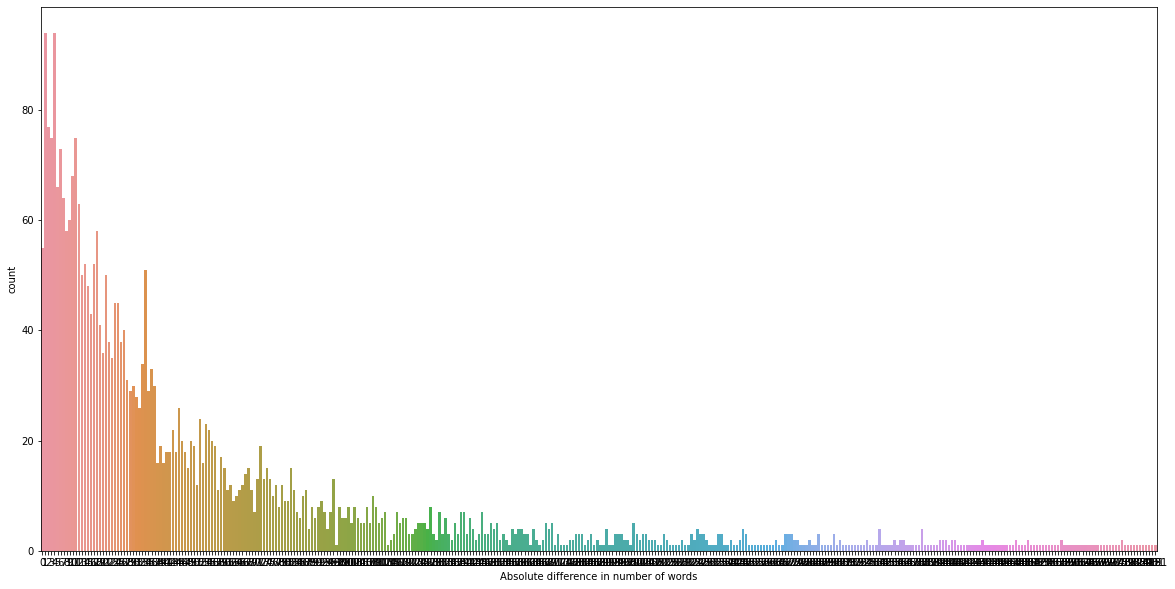

In [ ]:
plt.figure(figsize=(20, 10))
dist = df['abs_len_diff'][0:10000].values
dist.min()
plt.xlabel('Absolute difference in number of words')
sns.countplot(dist)
plt.show()

# ***TSNE Visualization***

In [ ]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3328 samples in 0.005s...
[t-SNE] Computed neighbors for 3328 samples in 0.217s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3328
[t-SNE] Computed conditional probabilities for sample 2000 / 3328
[t-SNE] Computed conditional probabilities for sample 3000 / 3328
[t-SNE] Computed conditional probabilities for sample 3328 / 3328
[t-SNE] Mean sigma: 0.125041
[t-SNE] Computed conditional probabilities in 0.178s
[t-SNE] Iteration 50: error = 77.5219879, gradient norm = 0.0676628 (50 iterations in 1.706s)
[t-SNE] Iteration 100: error = 69.0956039, gradient norm = 0.0156198 (50 iterations in 1.184s)
[t-SNE] Iteration 150: error = 67.5449066, gradient norm = 0.0087653 (50 iterations in 1.176s)
[t-SNE] Iteration 200: error = 67.0033035, gradient norm = 0.0061945 (50 iterations in 1.141s)
[t-SNE] Iteration 250: error = 66.6977234, gradient norm = 0.0056643 (50 iterations in 1.152s)
[t-SNE] KL divergence after 250 iterati

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


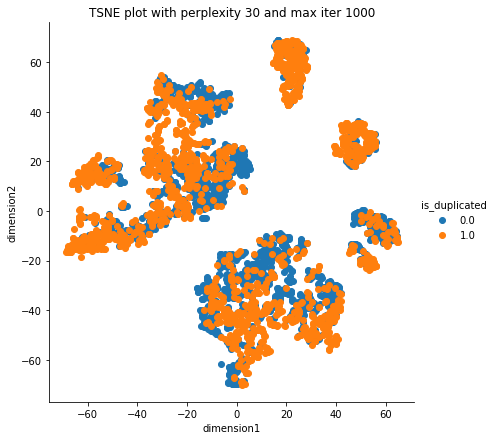

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)
#tsne result will appear as 2 columns.We have to plot it
# creating a new data frame which help us in ploting the tsne_result
tsne_new = np.vstack((tsne2d.T,dfp_subsampled['is_duplicate'])).T
df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2",
"is_duplicated"))
# Ploting the result
sns.FacetGrid(df, hue="is_duplicated", size=6).map(plt.scatter, 'dimension1',
'dimension2').add_legend()
plt.title("TSNE plot with perplexity 30 and max iter 1000")
plt.show()